In [184]:
%load_ext autoreload
%autoreload 2
import torch
from torch_geometric.data import Data
from MVC_env import MVC_environement
from DQN_network import Agent
import networkx as nx
from utils import mvc_bb , validation_graph_gen
import random
import numpy as np
import math
from tqdm import tqdm_notebook as tqdm
from collections import namedtuple
from copy import deepcopy
from torch_geometric.nn import dense_diff_pool 
np.random.seed(19960214)
random.seed(19960214)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
g = nx.erdos_renyi_graph(n = 20 , p = 0.15)
env = MVC_environement(g)
Xv , graph = env.reset_env()
graph = torch.unsqueeze(graph , 0)

In [147]:
X_new , adj_plum , _ , _ = dense_diff_pool(Xv , graph , graph)


[1]

In [209]:
def training_validation( validation_a , validation_bs , validation_per_epoch = 30 , num_validation = 20  ,
                        parameter_list = [[50,'er',0.15]] , device = 'cuda:1' , 
                        opt_train = -1 , opt_val=[] ):

    agent = Agent()
    EPS_START = 1.00
    EPS_END = 0.05
    EPS_DECAY = 10000
    steps_done = 0
    N_STEP = 2
    MAX_EPISODE = validation_per_epoch * num_validation + 1
    fitted_q_exp = namedtuple("fitted_exp" , ['graph','Xv','action','reward'])
    experience = namedtuple("experience" , ['graph','Xv','action','reward','next_Xv','is_done'])
    another_result = [[] for _ in range(len(validation_bs))]
    validation_result = []
    
    print('training candidate',parameter_list)
    TOTAL_PARA = len(parameter_list)
    for e in tqdm(range(MAX_EPISODE)):
        
        graph_size , type_train , density = parameter_list[e%TOTAL_PARA]
        
        def density_to_edge_ba(n , p):
            return math.ceil( p *n  /2)
        #p = np.random.uniform(0.05,0.3)
        if type_train == 'er':
            g = nx.erdos_renyi_graph(n = graph_size , p = density)
        elif type_train == 'ba':
            ba_m = density_to_edge_ba(graph_size , density)
            g = g = nx.barabasi_albert_graph(graph_size , ba_m)
        else:
            raise 'Not Implemented'
            
        env = MVC_environement(g)
        
        Xv , graph = env.reset_env()
        Xv = Xv.clone()
        graph = torch.unsqueeze(graph,  0)
        done = False
        non_selected = list(np.arange(env.num_nodes))
        selected = []
        N = 0
        fitted_experience_list = []
        reward_list = []
        agent.new_epsiode()
        while done == False:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
            if np.random.uniform() > eps_threshold:
                val = agent(graph , Xv)[0]
                val[selected] = -float('inf')
                action = int(torch.argmax(val).item())
            else:
                action = int(np.random.choice(non_selected))
                
            Xv_next , reward , done = env.take_action(action)
            Xv_next = Xv_next.clone()
            fit_ex = fitted_q_exp(graph , Xv , action , reward)
            fitted_experience_list.append(fit_ex)
            non_selected.remove(action)
            selected.append(action)
            N += 1 
            reward_list.append(reward)
            
            if N >= N_STEP:
                n_reward = sum(reward_list)
                n_prev_ex = fitted_experience_list[0]
                n_graph = n_prev_ex.graph
                n_Xv = n_prev_ex.Xv
                n_action = n_prev_ex.action
                ex = experience(n_graph , n_Xv , torch.tensor([n_action]) , torch.tensor([n_reward]) , Xv_next , done)
                agent.buffer.push(ex)
                fitted_experience_list.pop(0)
                reward_list.pop(0)
                
            Xv = Xv_next
            steps_done += 1
            
            agent.train()
        if e > 0 and e % 8 == 0:
            agent.update_target_network()
            
        if e > 0 and e % validation_per_epoch == 0:
            v = agent.get_val_result( validation_a )
            validation_result.append(v / opt_train)
            for i , validation_b in enumerate(validation_bs):
                v = agent.get_val_result(validation_b )
                another_result[i].append(v / opt_val[i])
                
    return validation_result , another_result  , agent

training  (50, 'er', 0.15)
training candidate [(50, 'er', 0.15), (50, 'er', 0.3)]


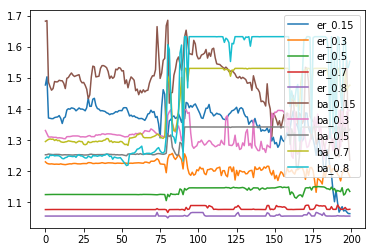

In [219]:
import os
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
graph_size_list = [50]
graph_type_list = ['er' , 'ba']
density_list = [0.15,0.3,0.5,0.7,0.8]

parameter_list = list(itertools.product(graph_size_list , graph_type_list ,density_list))
N = len(parameter_list)

VALIDATION_GRAPH_NUM = 150
performance_dict = {}
all_graphs = []
opt_results = []
for i in range(N):
    train_size = parameter_list[i][0]
    train_type = parameter_list[i][1]
    train_density = parameter_list[i][2]
    
    train_graphs = validation_graph_gen(n = train_size , p = train_density 
                                        , num = VALIDATION_GRAPH_NUM , graph_type=train_type)
    
    all_graphs.append(train_graphs)

for i in range(N):
    
    cur_res = []
    
    for j in tqdm(range(VALIDATION_GRAPH_NUM)):
        cur_g = all_graphs[i][j]
        C = mvc_bb(cur_g , len(cur_g.nodes()) , [])
        cur_res.append(len(C))
    opt_results.append(sum(cur_res)/len(cur_res))
for i in range(1):
    train_size = parameter_list[i][0]
    train_type = parameter_list[i][1]
    train_density = parameter_list[i][2]
    legend_word = ['{}_{}'.format(train_type,train_density)]
    opt_train = opt_results[i]
    train_graphs = all_graphs[i][:]
    opt_vals = []
    validation_anothers = []
    print('training ',parameter_list[i])
    for j in range(N):
        
        if i == j:
            continue
        val_size = parameter_list[j][0]
        val_type = parameter_list[j][1]
        val_density = parameter_list[j][2]
        
        validation_anothers.append(all_graphs[j][:])
        opt_vals.append(opt_results[j])
        legend_word.append('{}_{}'.format(val_type,val_density))
    validation_result , another_result  , dqn = training_validation(train_graphs , validation_anothers,
                                                                              num_validation=200 , validation_per_epoch=60,
                                                                              parameter_list = parameter_list[0:2] , 
                                                                                    opt_train=opt_train,
                                                                              opt_val = opt_vals, device='cuda:0')
    plt.plot(validation_result)
    performance_dict[legend_word[0]] = {legend_word[0]:validation_result}
    for v , l in zip(another_result , legend_word[1:]):
        plt.plot(v)
        performance_dict[legend_word[0]][l] = v
    plt.legend(legend_word)
    plt.show()


(1.0, 1.3233333333333335)

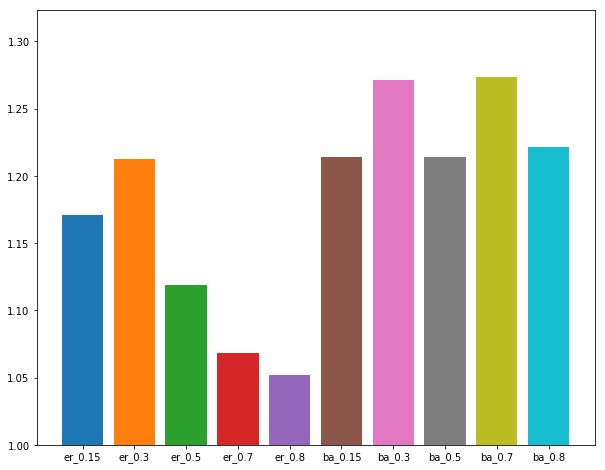

In [208]:
tmp_data3 = deepcopy(performance_dict['er_0.15'])
plt.figure(figsize=(10,8))
idx = 0
ticks_word = []
y_upper = 0
for k , v in tmp_data3.items():
    y_upper = max(y_upper , min(v))
    plt.bar(idx,min(v))
    idx += 1
    ticks_word.append(k)
plt.xticks(np.arange(len(tmp_data)),ticks_word)
plt.ylim(1.0,y_upper+0.05)

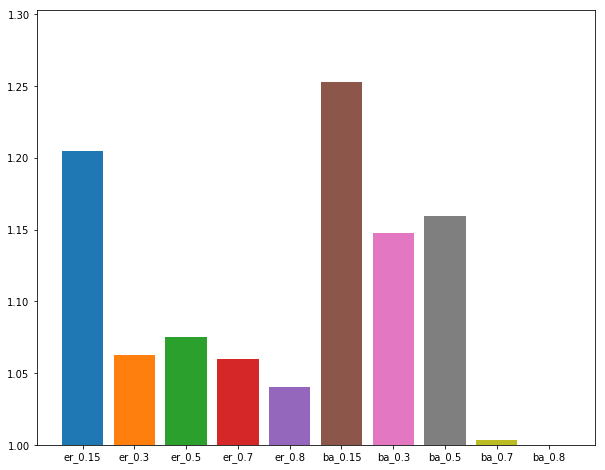

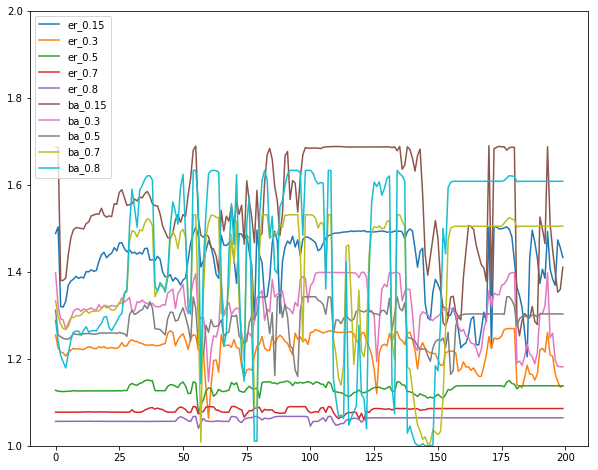

In [218]:
#N = 50, using all
tmp_data4 = deepcopy(performance_dict['er_0.15'])
plt.figure(figsize=(10,8))
idx = 0
ticks_word = []
y_upper = 0
for k , v in tmp_data4.items():
    y_upper = max(y_upper , min(v))
    plt.bar(idx,min(v))
    idx += 1
    ticks_word.append(k)
plt.xticks(np.arange(len(tmp_data)),ticks_word)
plt.ylim(1.0,y_upper+0.05)
plt.show()

plt.figure(figsize=(10,8))

for k , v in tmp_data4.items():
    plt.plot(v)
plt.legend(ticks_word)
plt.ylim(1.0,2)
plt.show()


(1.0, 1.1)

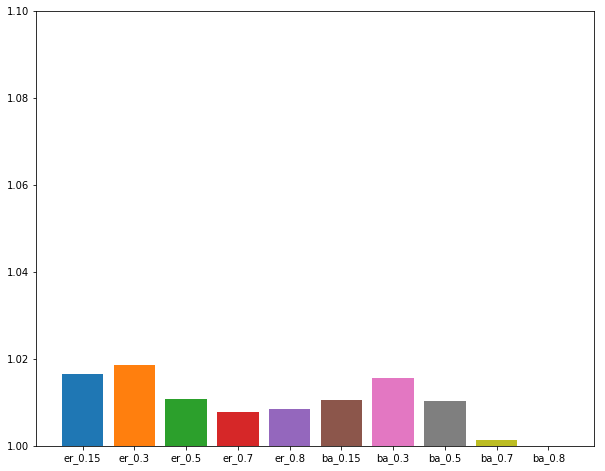

In [195]:
tmp_data2 = deepcopy(performance_dict['er_0.15'])
plt.figure(figsize=(10,8))
idx = 0
ticks_word = []
for k , v in tmp_data2.items():
    plt.bar(idx,min(v))
    idx += 1
    ticks_word.append(k)
plt.xticks(np.arange(len(tmp_data)),ticks_word)
plt.ylim(1.0,1.1)

(1.0, 1.1)

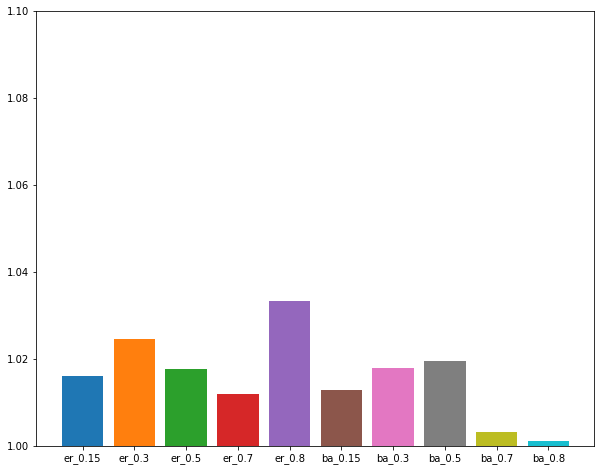

In [190]:
#Train with all distribution
#0309
#tmp_data = deepcopy(performance_dict['er_0.15'])
plt.figure(figsize=(10,8))
idx = 0
ticks_word = []
for k , v in tmp_data.items():
    plt.bar(idx,min(v))
    idx += 1
    ticks_word.append(k)
plt.xticks(np.arange(len(tmp_data)),ticks_word)
plt.ylim(1.0,1.1)